Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
import matplotlib.pyplot as plt


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Data Preprocessing

In [ ]:
transform_stl = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_mnist = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
class STL10Binary(Dataset):
    def __init__(self, data_path, split='train', transform=transform_stl):
        self.transform = transform
        self.data_path = data_path

        if split == 'train':
            self.data = np.fromfile(os.path.join(data_path, 'train_X.bin'), dtype=np.uint8).reshape(-1, 3, 96, 96)
            self.labels = np.fromfile(os.path.join(data_path, 'train_y.bin'), dtype=np.uint8) - 1
        else:
            self.data = np.fromfile(os.path.join(data_path, 'test_X.bin'), dtype=np.uint8).reshape(-1, 3, 96, 96)
            self.labels = np.fromfile(os.path.join(data_path, 'test_y.bin'), dtype=np.uint8) - 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = torch.tensor(self.data[idx], dtype=torch.float32) / 255.0
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        image = to_pil_image(image)
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
data_dir = "data/stl10_binary"
stl_train = STL10Binary(data_path=data_dir, split='train', transform=transform_stl)
stl_test = STL10Binary(data_path=data_dir, split='test', transform=transform_stl)

mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform_mnist)
mnist_test = datasets.MNIST(root="./data", train=False, download=True, transform=transform_mnist)

stl_train_loader = DataLoader(stl_train, batch_size=64, shuffle=True)
stl_test_loader = DataLoader(stl_test, batch_size=64, shuffle=False)

mnist_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)


Pre-Train ResNet-34 on STL-10

In [ ]:
model = models.resnet34(weights=None)
model.fc = nn.Linear(512, 10)
model = model.to(device)

In [ ]:
def train_model(model, train_loader, epochs=25, lr=0.001, freeze=False):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    if freeze:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True

    model.train()
    for epoch in range(epochs):
        total_loss, correct = 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()

        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(train_loader):.4f} | Accuracy: {correct/len(train_loader.dataset):.4f}")

    torch.save(model.state_dict(), 'model_resnet34.pth')

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"Test Accuracy: {correct/total:.4f}")
    print(classification_report(all_labels, all_preds, digits=4))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
def show_predictions(model, test_loader, num_images=10):
    model.eval()
    images_shown = 0
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(num_images):
                img = images[i].cpu().permute(1, 2, 0).numpy()
                axes[i].imshow(img)
                axes[i].set_title(f"Pred: {preds[i].item()}")
                axes[i].axis("off")
                images_shown += 1
                if images_shown >= num_images:
                    break
            if images_shown >= num_images:
                break

    plt.show()

In [ ]:
print("Pre-training on STL-10...")
train_model(model, stl_train_loader, epochs=30, lr=0.001)

Pre-training on STL-10...
Epoch 1/30 | Loss: 1.8388 | Accuracy: 0.3056
Epoch 2/30 | Loss: 1.4918 | Accuracy: 0.4334
Epoch 3/30 | Loss: 1.3610 | Accuracy: 0.4882
Epoch 4/30 | Loss: 1.2164 | Accuracy: 0.5566
Epoch 5/30 | Loss: 1.1131 | Accuracy: 0.5998
Epoch 6/30 | Loss: 0.9952 | Accuracy: 0.6462
Epoch 7/30 | Loss: 0.9085 | Accuracy: 0.6718
Epoch 8/30 | Loss: 0.8221 | Accuracy: 0.7028
Epoch 9/30 | Loss: 0.6922 | Accuracy: 0.7508
Epoch 10/30 | Loss: 0.5664 | Accuracy: 0.7952
Epoch 11/30 | Loss: 0.5032 | Accuracy: 0.8182
Epoch 12/30 | Loss: 0.3780 | Accuracy: 0.8632
Epoch 13/30 | Loss: 0.3100 | Accuracy: 0.8898
Epoch 14/30 | Loss: 0.3921 | Accuracy: 0.8692
Epoch 15/30 | Loss: 0.2164 | Accuracy: 0.9308
Epoch 16/30 | Loss: 0.1610 | Accuracy: 0.9436
Epoch 17/30 | Loss: 0.1547 | Accuracy: 0.9524
Epoch 18/30 | Loss: 0.2527 | Accuracy: 0.9150
Epoch 19/30 | Loss: 0.0840 | Accuracy: 0.9706
Epoch 20/30 | Loss: 0.0363 | Accuracy: 0.9888
Epoch 21/30 | Loss: 0.1322 | Accuracy: 0.9578
Epoch 22/30 | Los


Evaluating on STL-10...
Test Accuracy: 0.6035
              precision    recall  f1-score   support

           0     0.8939    0.6000    0.7180       800
           1     0.4638    0.6650    0.5465       800
           2     0.7240    0.8363    0.7761       800
           3     0.4802    0.4700    0.4750       800
           4     0.6182    0.5687    0.5924       800
           5     0.4068    0.3438    0.3726       800
           6     0.5940    0.6438    0.6179       800
           7     0.5283    0.4550    0.4889       800
           8     0.6818    0.8625    0.7616       800
           9     0.7504    0.5900    0.6606       800

    accuracy                         0.6035      8000
   macro avg     0.6141    0.6035    0.6010      8000
weighted avg     0.6141    0.6035    0.6010      8000



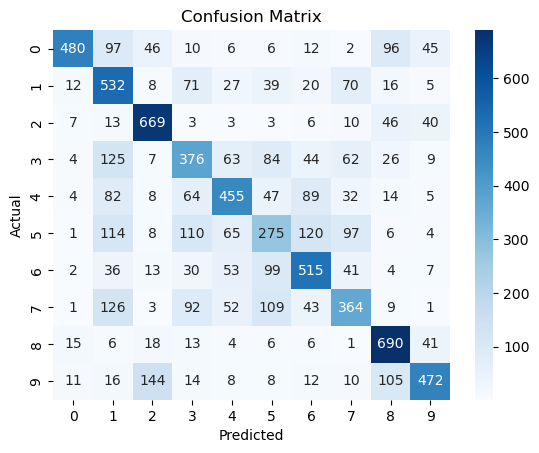

In [ ]:
print("\nEvaluating on STL-10...")
evaluate(model, stl_test_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7882353..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..0.4901961].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8901961].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range 

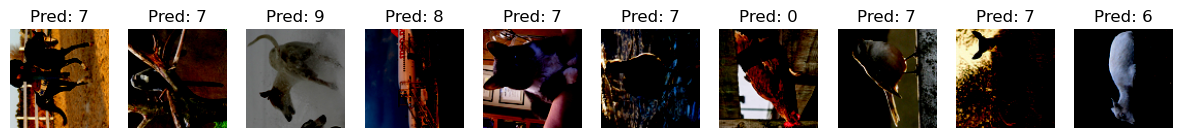

In [ ]:
show_predictions(model, stl_test_loader)

In [ ]:
def train_model(model, train_loader, epochs=25, lr=0.001, freeze=False):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    if freeze:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True

    model.train()
    for epoch in range(epochs):
        total_loss, correct = 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()

        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(train_loader):.4f} | Accuracy: {correct/len(train_loader.dataset):.4f}")

Transfer Learning to MNIST - Train Only Linear Layers

In [ ]:
model.load_state_dict(torch.load("model_resnet34.pth"))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
print("\nTransfer Learning - Training only FC Layer on MNIST...")
train_model(model, mnist_train_loader, epochs=10, lr=0.001, freeze=True)


Transfer Learning - Training only FC Layer on MNIST...
Epoch 1/10 | Loss: 1.1757 | Accuracy: 0.6663
Epoch 2/10 | Loss: 0.6032 | Accuracy: 0.8342
Epoch 3/10 | Loss: 0.4738 | Accuracy: 0.8704
Epoch 4/10 | Loss: 0.4075 | Accuracy: 0.8873
Epoch 5/10 | Loss: 0.3629 | Accuracy: 0.8984
Epoch 6/10 | Loss: 0.3309 | Accuracy: 0.9074
Epoch 7/10 | Loss: 0.3097 | Accuracy: 0.9125
Epoch 8/10 | Loss: 0.2905 | Accuracy: 0.9177
Epoch 9/10 | Loss: 0.2754 | Accuracy: 0.9210
Epoch 10/10 | Loss: 0.2616 | Accuracy: 0.9257



Evaluating on MNIST...
Test Accuracy: 0.9291
              precision    recall  f1-score   support

           0     0.9679    0.9531    0.9604       980
           1     0.9789    0.9806    0.9798      1135
           2     0.9458    0.9293    0.9374      1032
           3     0.9602    0.8594    0.9070      1010
           4     0.9453    0.9511    0.9482       982
           5     0.8721    0.9249    0.8977       892
           6     0.9507    0.9269    0.9387       958
           7     0.8799    0.9475    0.9124      1028
           8     0.8617    0.9086    0.8846       974
           9     0.9315    0.9029    0.9170      1009

    accuracy                         0.9291     10000
   macro avg     0.9294    0.9284    0.9283     10000
weighted avg     0.9306    0.9291    0.9293     10000



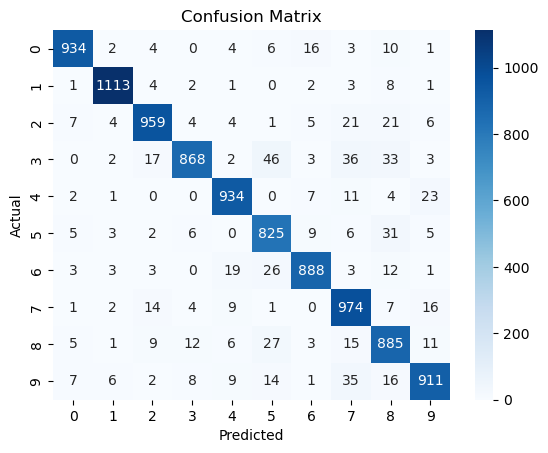

In [ ]:
print("\nEvaluating on MNIST...")
evaluate(model, mnist_test_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid ran

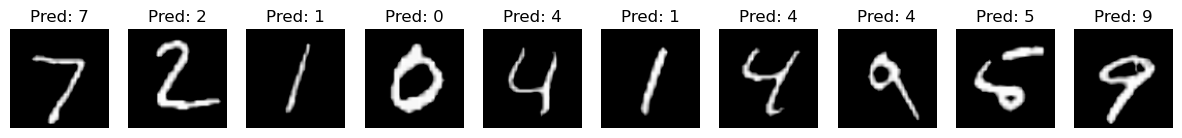

In [ ]:
show_predictions(model, mnist_test_loader)

Transfer Learning to MNIST - Freeze Initial Layers, Train Others

In [ ]:
model.load_state_dict(torch.load("model_resnet34.pth"))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def unfreeze_last_layers(model, num_layers=3):
    for param in model.parameters():
        param.requires_grad = False
    for layer in list(model.children())[-num_layers:]:
        for param in layer.parameters():
            param.requires_grad = True

print("\nFine-tuning last layers on MNIST...")
unfreeze_last_layers(model, num_layers=3)
train_model(model, mnist_train_loader, epochs=10, lr=0.0005)



Fine-tuning last layers on MNIST...
Epoch 1/10 | Loss: 0.2522 | Accuracy: 0.9294
Epoch 2/10 | Loss: 0.0606 | Accuracy: 0.9808
Epoch 3/10 | Loss: 0.0417 | Accuracy: 0.9868
Epoch 4/10 | Loss: 0.0299 | Accuracy: 0.9901
Epoch 5/10 | Loss: 0.0238 | Accuracy: 0.9923
Epoch 6/10 | Loss: 0.0217 | Accuracy: 0.9927
Epoch 7/10 | Loss: 0.0153 | Accuracy: 0.9951
Epoch 8/10 | Loss: 0.0160 | Accuracy: 0.9946
Epoch 9/10 | Loss: 0.0126 | Accuracy: 0.9956
Epoch 10/10 | Loss: 0.0124 | Accuracy: 0.9958



Evaluating on MNIST...
Test Accuracy: 0.9846
              precision    recall  f1-score   support

           0     0.9868    0.9949    0.9909       980
           1     0.9938    0.9930    0.9934      1135
           2     0.9762    0.9942    0.9851      1032
           3     0.9822    0.9861    0.9842      1010
           4     0.9857    0.9817    0.9837       982
           5     0.9843    0.9809    0.9826       892
           6     0.9916    0.9812    0.9864       958
           7     0.9796    0.9815    0.9806      1028
           8     0.9816    0.9846    0.9831       974
           9     0.9839    0.9663    0.9750      1009

    accuracy                         0.9846     10000
   macro avg     0.9846    0.9844    0.9845     10000
weighted avg     0.9846    0.9846    0.9846     10000



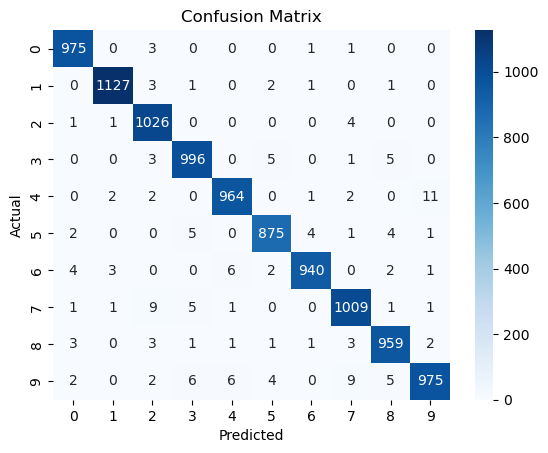

In [ ]:
print("\nEvaluating on MNIST...")
evaluate(model, mnist_test_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid ran

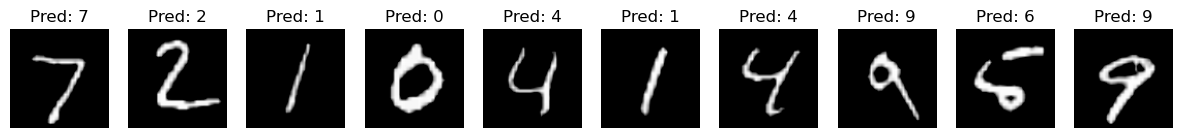

In [ ]:
show_predictions(model, mnist_test_loader)

Transfer Learning to MNIST - Finetune Entire Network

In [ ]:
model.load_state_dict(torch.load("model_resnet34.pth"))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for param in model.parameters():
    param.requires_grad = True
print("\nFine-tuning entire network on MNIST...")
train_model(model, mnist_train_loader, epochs=10, lr=0.0001)


Fine-tuning entire network on MNIST...
Epoch 1/10 | Loss: 0.2515 | Accuracy: 0.9365
Epoch 2/10 | Loss: 0.0412 | Accuracy: 0.9875
Epoch 3/10 | Loss: 0.0243 | Accuracy: 0.9925
Epoch 4/10 | Loss: 0.0173 | Accuracy: 0.9946
Epoch 5/10 | Loss: 0.0121 | Accuracy: 0.9959
Epoch 6/10 | Loss: 0.0100 | Accuracy: 0.9966
Epoch 7/10 | Loss: 0.0076 | Accuracy: 0.9976
Epoch 8/10 | Loss: 0.0085 | Accuracy: 0.9972
Epoch 9/10 | Loss: 0.0048 | Accuracy: 0.9985
Epoch 10/10 | Loss: 0.0063 | Accuracy: 0.9980



Evaluating on MNIST...
Test Accuracy: 0.9935
              precision    recall  f1-score   support

           0     0.9889    0.9980    0.9934       980
           1     0.9956    1.0000    0.9978      1135
           2     0.9923    0.9952    0.9937      1032
           3     0.9892    0.9980    0.9936      1010
           4     0.9879    0.9969    0.9924       982
           5     0.9989    0.9865    0.9927       892
           6     0.9958    0.9854    0.9906       958
           7     0.9980    0.9932    0.9956      1028
           8     0.9938    0.9938    0.9938       974
           9     0.9950    0.9861    0.9905      1009

    accuracy                         0.9935     10000
   macro avg     0.9935    0.9933    0.9934     10000
weighted avg     0.9935    0.9935    0.9935     10000



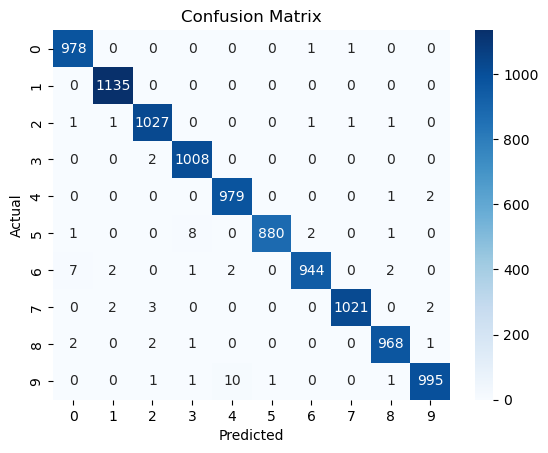

In [ ]:
print("\nEvaluating on MNIST...")
evaluate(model, mnist_test_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid ran

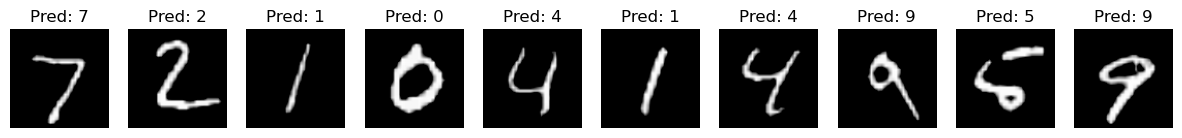

In [ ]:
show_predictions(model, mnist_test_loader)